# This notebook is related to the Coursera Capstone Project

#### (last course of the IBM Data Science Professional Certificate)

## Introduction

In this project we will study the possibility to predict the severity of a car accident taking into account only
"environment" variables (road condition, light condition, weather condition) and date/time information. In case
the prediction is accurate, it could be useful for authorities in order to either minimize the potential severity, by
means of taking actions for specific riskier conditions, or resources deployment, management and distribution.

## Initialization and data import

In [1]:
# The first step will be importing the needed libraries for the project and setting some default values.
import itertools
import pandas as pd
import numpy as np
import datetime as dt
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', None)

In [2]:
# Second step will be importing the dataset and creating a dataframe
df_raw =  pd.read_csv("Data-Collisions.csv", low_memory = False)
print(df_raw.shape)
df_raw.head()

(194673, 38)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Data Analysis and Preparation

### Data visualization and preprocessing

In [3]:
# Once we got the dataset, we will start analysing its contents in order to define how to face the problem. Let's start
# retrieving all the available columns and its data types.
df_raw.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

In [4]:
# Third step will be selecting the features that we want to consider for the analysis, as well as the label column. We
# will select those features that are "external" (date and time, weather condition information, road condition and light
# condition). 
column_filter = ['SEVERITYCODE', 'INCDTTM', 'WEATHER', 'ROADCOND', 'LIGHTCOND']
df = df_raw[column_filter].copy()
df.head()

,SEVERITYCODE,INCDTTM,WEATHER,ROADCOND,LIGHTCOND
0,2,3/27/2013 2:54:00 PM,Overcast,Wet,Daylight
1,1,12/20/2006 6:55:00 PM,Raining,Wet,Dark - Street Lights On
2,1,11/18/2004 10:20:00 AM,Overcast,Dry,Daylight
3,1,3/29/2013 9:26:00 AM,Clear,Dry,Daylight
4,2,1/28/2004 8:04:00 AM,Raining,Wet,Daylight


In [5]:
# Next step will be to convert the INCDTTM feature into a datetime object
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

# Now we can check the number of records and the types of the dataframe columns
print(df.shape,'\n')
df.dtypes

(194673, 5) 



SEVERITYCODE             int64
INCDTTM         datetime64[ns]
WEATHER                 object
ROADCOND                object
LIGHTCOND               object
dtype: object

In [6]:
# We will create new features that group the date and time information to allow us an analysis of the data in different
# time intervals. We generate new columns 'WEEKDAY', 'WEEK' and 'HOUR' to analyze the distribution of the accidents
# during the week, for each week of the year and during each hour of the day respectively.
df['WEEKDAY'] = df['INCDTTM'].dt.dayofweek
df['WEEK'] = df['INCDTTM'].dt.strftime("%V")
df['HOUR'] = df['INCDTTM'].dt.hour

# Finally, we will drop the 'INCDTTM' column, as it won't be useful for the rest of the analysis.
df.drop(columns = 'INCDTTM',inplace = True)

# Let's visualize the resulting dataframe and the number of remaining records.
print(df.shape, '\n')
df.head()

(194673, 7) 



,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,WEEKDAY,WEEK,HOUR
0,2,Overcast,Wet,Daylight,2,13,14
1,1,Raining,Wet,Dark - Street Lights On,2,51,18
2,1,Overcast,Dry,Daylight,3,47,10
3,1,Clear,Dry,Daylight,4,13,9
4,2,Raining,Wet,Daylight,2,05,8


In [7]:
# Before performing a deeper analysis, let's proceed to cleaning the dataset. To start with, we will eliminate the empty
# values of the WEEKDAY, WEEK, HOUR, WEATHER, ROADCOND and LIGHTCOND columns. First we replace the empty values (if any)
# with NaN and then we will erase the related rows from the dataset.
df['WEEKDAY'].replace('', np.nan, inplace = True)
df['WEEK'].replace('', np.nan, inplace = True)
df['HOUR'].replace('', np.nan, inplace = True)
df['WEATHER'].replace('', np.nan, inplace = True)
df['ROADCOND'].replace('', np.nan, inplace = True)
df['LIGHTCOND'].replace('', np.nan, inplace = True)

# Afterwards, we use the dropna function to eliminate the rows that contain this kind of value
df.dropna(subset = ['WEATHER', 'ROADCOND', 'LIGHTCOND', 'WEEKDAY', 'WEEK', 'HOUR'], inplace = True)

# Once done, we review again the size of the dataframe
df.shape

(189337, 7)

In [8]:
# Let's see now the values corresponding to the accident severity, the label that we want to predict. We will observe the
# SEVERITYCODE column.

print(df['SEVERITYCODE'].value_counts(), "\n")
df['SEVERITYCODE'].value_counts(normalize = True)

1    132285
2     57052
Name: SEVERITYCODE, dtype: int64 



1    0.698675
2    0.301325
Name: SEVERITYCODE, dtype: float64

WEEKDAY  SEVERITYCODE
0        1               0.694514
         2               0.305486
1        1               0.691442
         2               0.308558
2        1               0.692602
         2               0.307398
3        1               0.689244
         2               0.310756
4        1               0.701726
         2               0.298274
5        1               0.704840
         2               0.295160
6        1               0.721229
         2               0.278771
Name: SEVERITYCODE, dtype: float64 

Mean value for SEVERITYCODE = 1:  0.6993711465240889
Standard deviation value for SEVERITYCODE = 1:  0.011165922916318065
Mean value for SEVERITYCODE = 2:  0.30062885347591095
Standard deviation value for SEVERITYCODE = 1:  0.011165922916318058


([<matplotlib.axis.XTick at 0x1e58d0a4a48>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

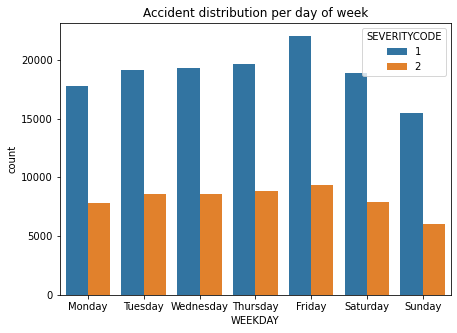

In [9]:
# From the previous analysis, we see that there is a strong bias in the dataset towards accidents with 'SEVERITYCODE'
# value 1 ('Property Damage Only Collision') as this represents the 70% of the records, while only a 30% of them
# correspond to the SEVERITYCODE value 2 ('Injury Collision'). We will need to take this into account when generating
# the train and test sets.

# Let's now analyse the relationship between the day of the week and the severity of the accidents.
weekday = df.groupby(['WEEKDAY'])['SEVERITYCODE'].value_counts(normalize = True)
print(weekday, '\n')
print("Mean value for SEVERITYCODE = 1: ", weekday.filter(like = ' 1' ,axis = 0).mean())
print("Standard deviation value for SEVERITYCODE = 1: ",weekday.filter(like = ' 1' ,axis = 0).std())
print("Mean value for SEVERITYCODE = 2: ",weekday.filter(like = ' 2' ,axis = 0).mean())
print("Standard deviation value for SEVERITYCODE = 1: ",weekday.filter(like = ' 2' ,axis = 0).std())
plt.figure(figsize = [7,5])
ax = sns.countplot(x = 'WEEKDAY', hue = 'SEVERITYCODE', data = df)
ax.set_title('Accident distribution per day of week')
locs, labels = plt.xticks()
plt.xticks(locs,['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [10]:
# We can see that, with a standard deviation of a 1,1%, a 67% - 33% relationship is present in average independently
# of the day of week. Let's now see if there is a clear relationship of the severity with the week of the year.
df_week = df.groupby(['WEEK'])['SEVERITYCODE'].value_counts(normalize = True)
df_week.head()

WEEK  SEVERITYCODE
01    1               0.711187
      2               0.288813
02    1               0.713176
      2               0.286824
03    1               0.708096
Name: SEVERITYCODE, dtype: float64

In [11]:
# We can calculate the mean and standard deviation of accidents with both severity types.
print("Low severity mean: ", df_week.filter(like = ' 1' ,axis = 0).mean())
print("Low severity standard deviation: ", df_week.filter(like = ' 1' ,axis = 0).std())
print("High severity mean: ", df_week.filter(like = ' 2' ,axis = 0).mean())
print("High severity standard deviation: ", df_week.filter(like = ' 2' ,axis = 0).std())

Low severity mean:  0.6992152870659436
Low severity standard deviation:  0.013580688900373776
High severity mean:  0.3007847129340561
High severity standard deviation:  0.013580688900373776


Text(0.5, 1.0, 'Low severity accidents per week')

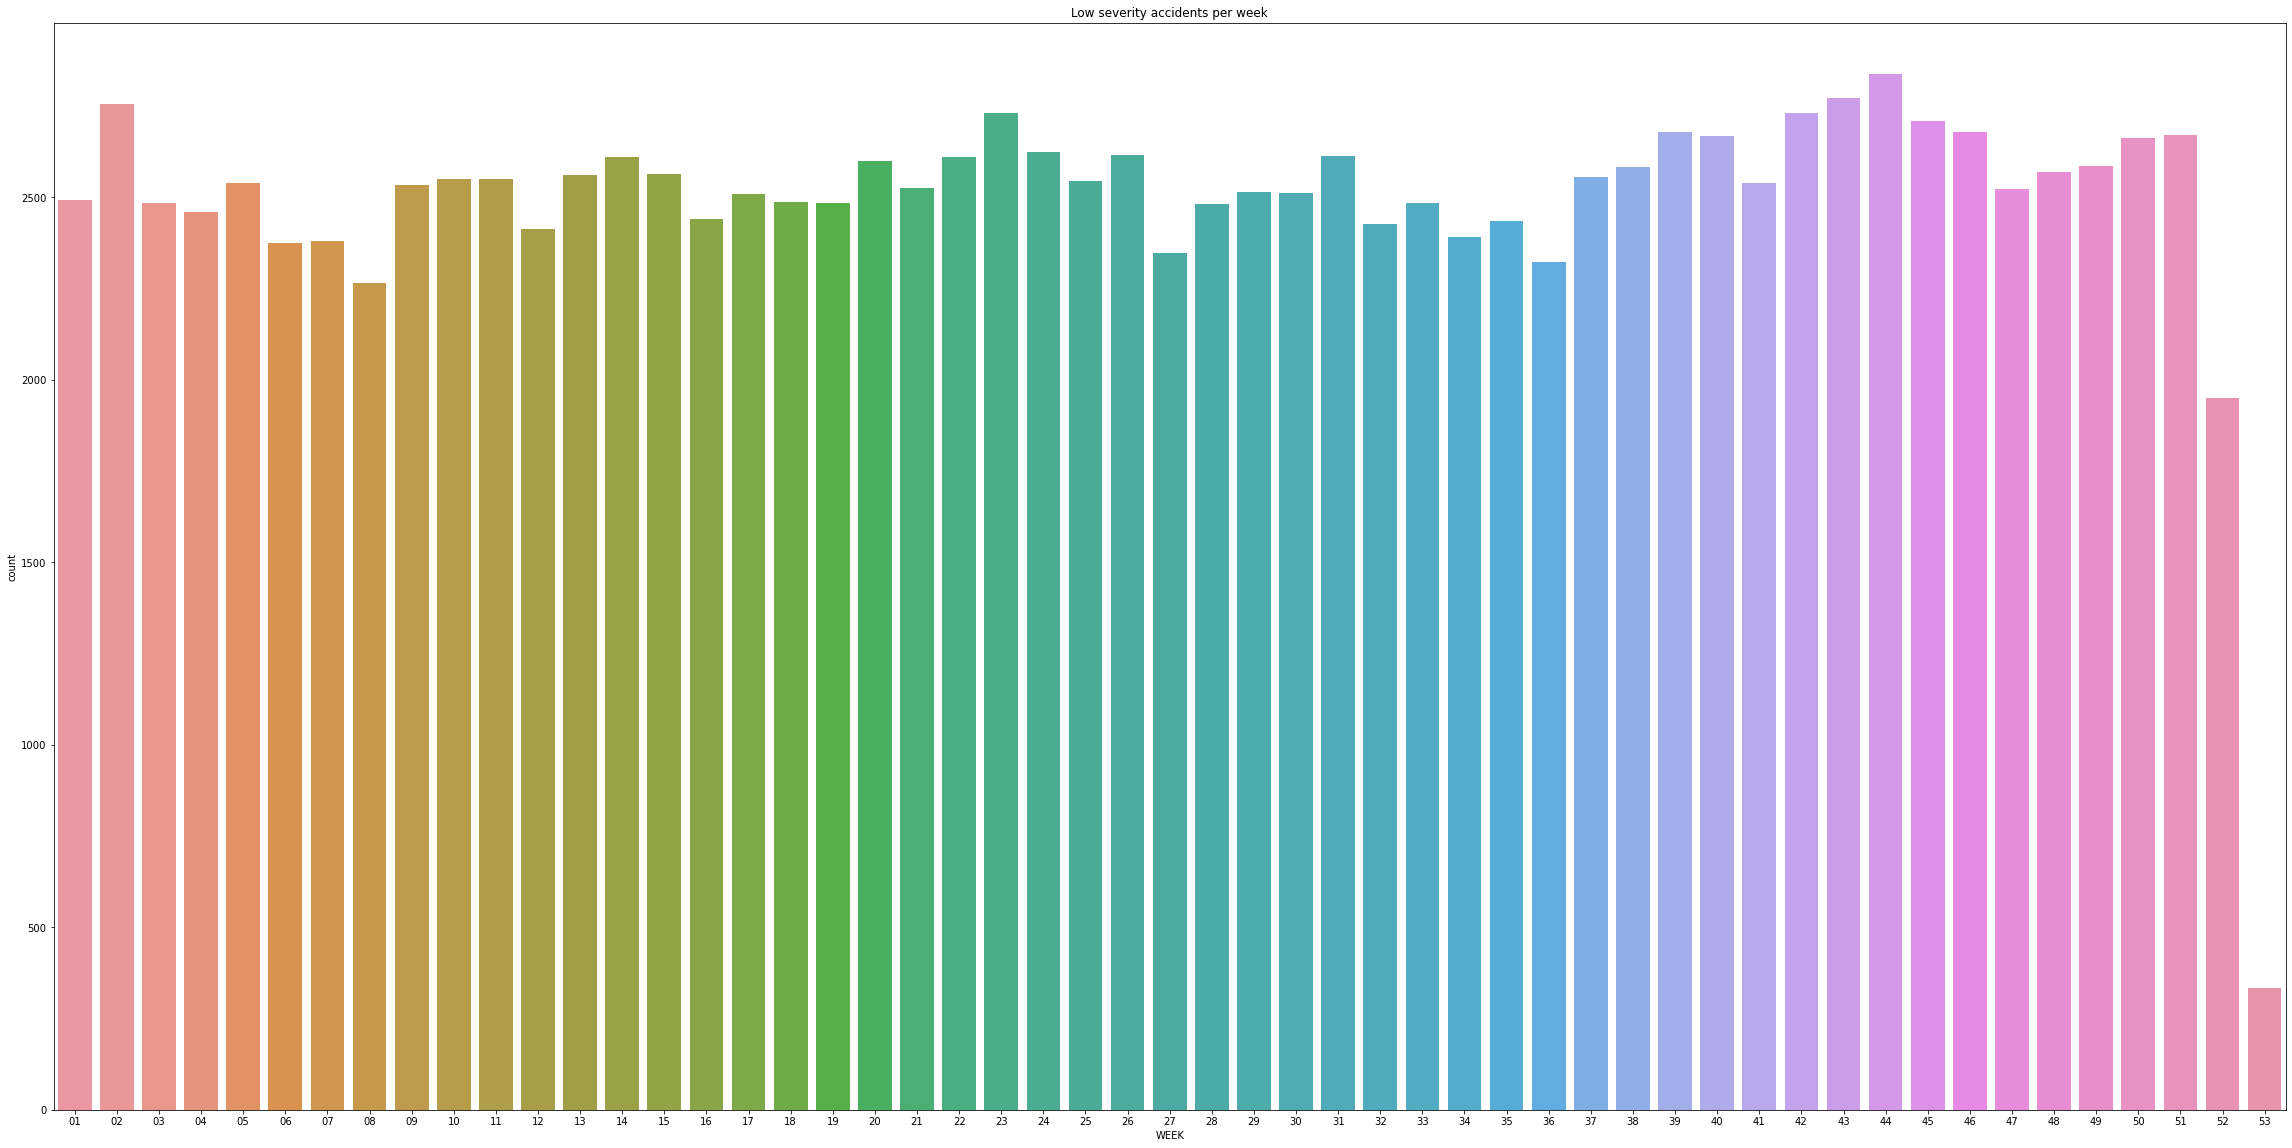

In [12]:
# Apparently, we have a 71% - 29% relationship result, similar to the one we got for the weekday, with 1,5% deviation.
# We can see it graphically, starting with the distribution of less severe accidents during the weeks of the year.
plt.figure(figsize = [40,20])
ax = sns.countplot(x = 'WEEK', data = df[df.SEVERITYCODE == 1])
ax.set_title('Low severity accidents per week')

Text(0.5, 1.0, 'High severity accidents per week')

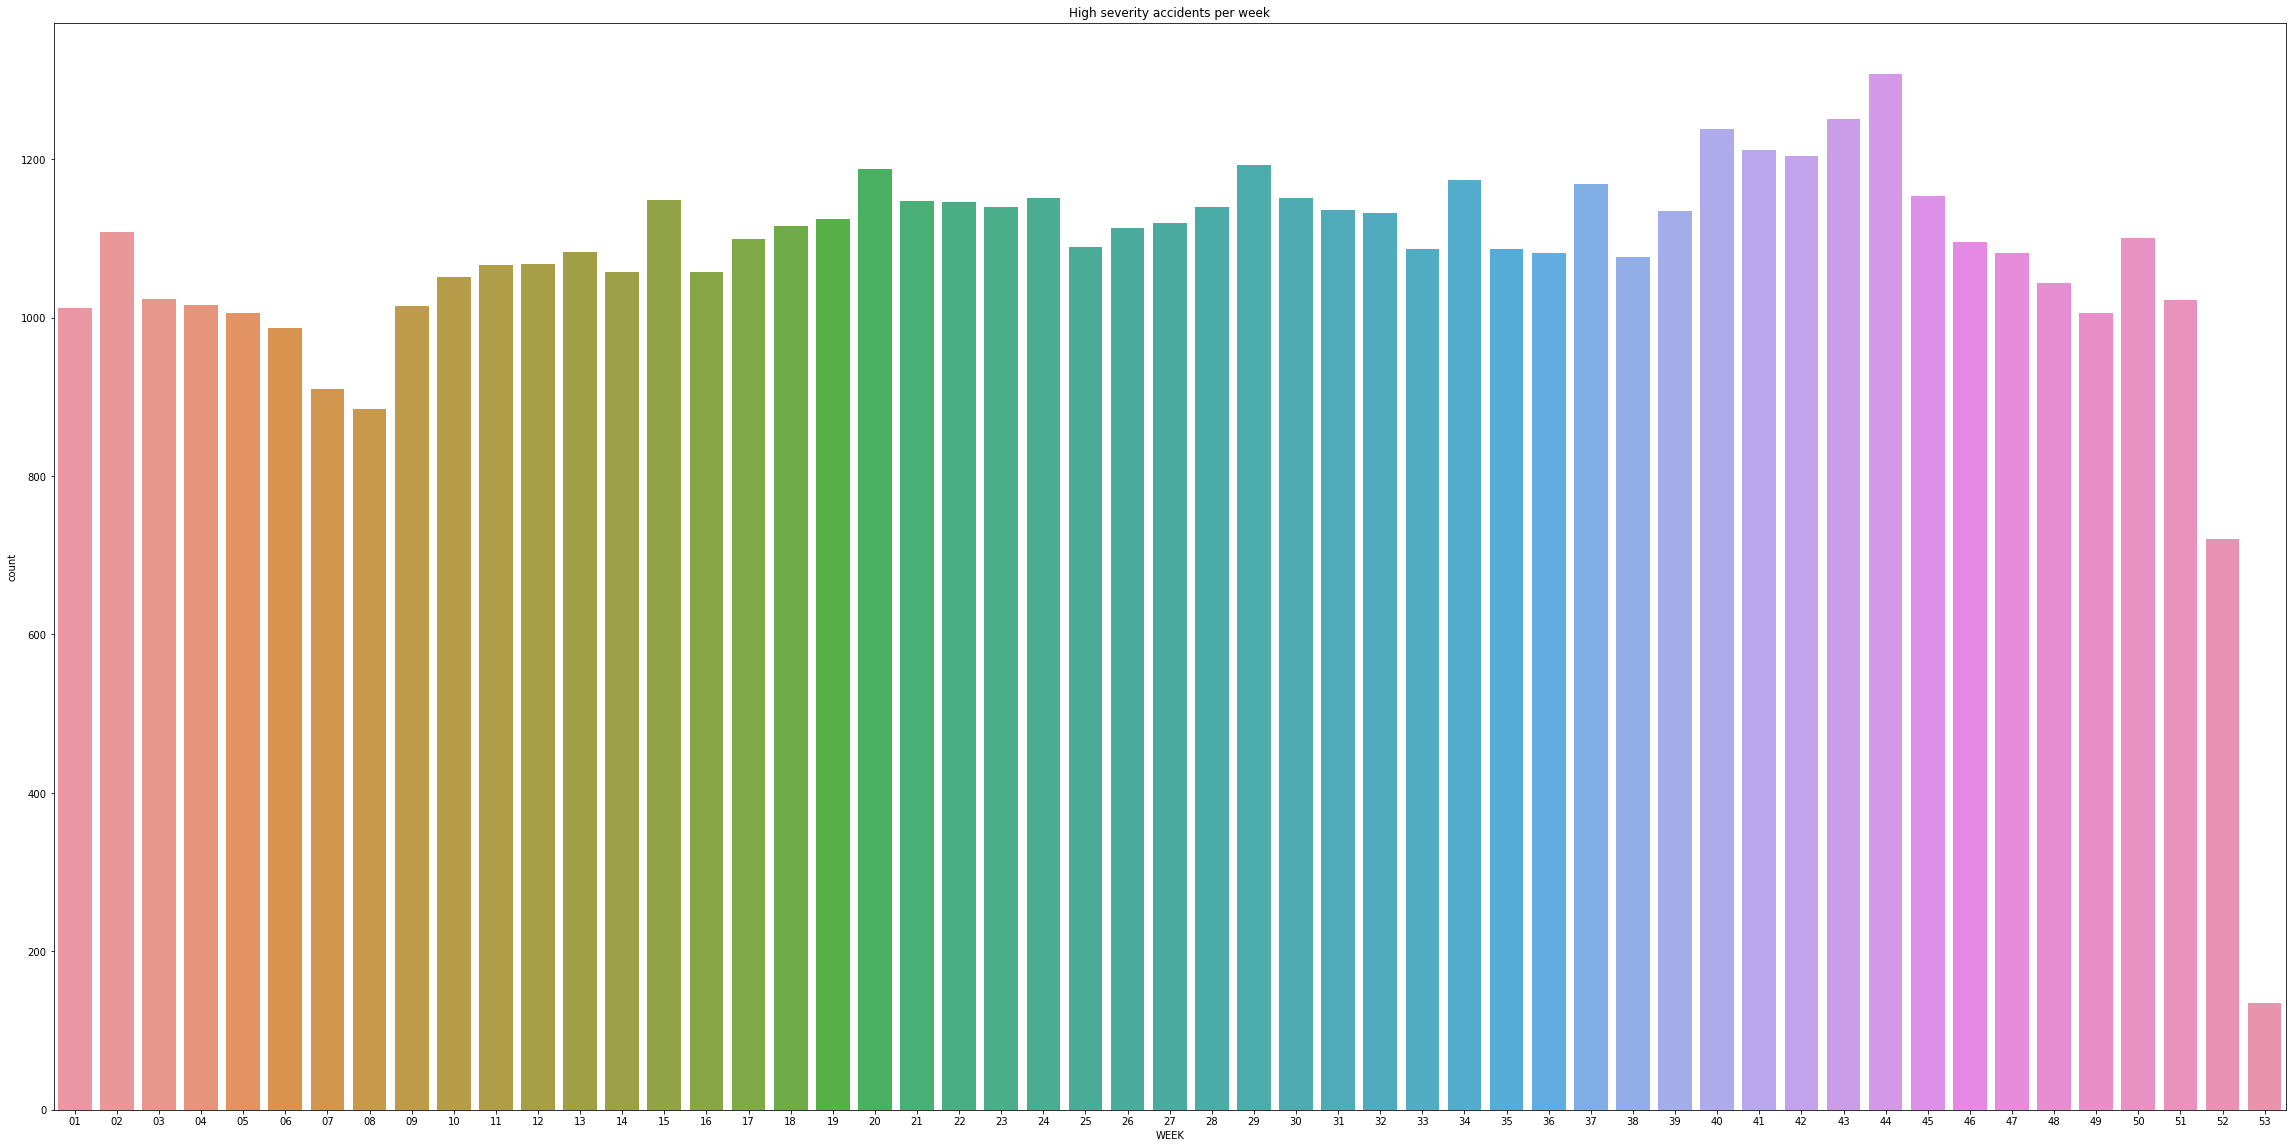

In [13]:
# And now representing the distribution of the most severe ones:
plt.figure(figsize = [40,20])
ax = sns.countplot(x = 'WEEK', data = df[df.SEVERITYCODE == 2])
ax.set_title('High severity accidents per week')

HOUR  SEVERITYCODE
0     1               0.721155
      2               0.278845
1     1               0.755804
      2               0.244196
2     1               0.759006
Name: SEVERITYCODE, dtype: float64
Low severity mean:  0.7087636962306053
Low severity standard deviation:  0.03715340837025098
High severity mean:  0.29123630376939486
High severity standard deviation:  0.03715340837025099


Text(0.5, 1.0, 'Accident distribution per hour')

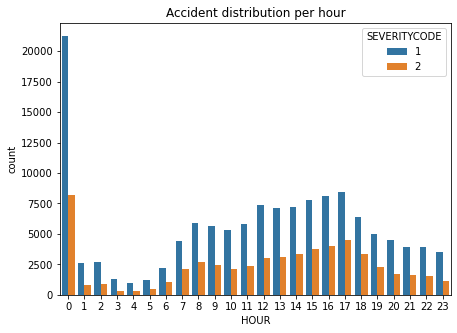

In [14]:
# We can see that both graphics have, approximately, the same shape, confirming our hypothesis.
# The last time parameter to observe will be the hourly distribution. Let's see if accident severity has a strong
# dependence on the hour of the day
df_hour = df.groupby(['HOUR'])['SEVERITYCODE'].value_counts(normalize = True)
print(df_hour.head())
print("Low severity mean: ", df_hour.filter(like = ' 1' ,axis = 0).mean())
print("Low severity standard deviation: ", df_hour.filter(like = ' 1' ,axis = 0).std())
print("High severity mean: ", df_hour.filter(like = ' 2' ,axis = 0).mean())
print("High severity standard deviation: ", df_hour.filter(like = ' 2' ,axis = 0).std())
plt.figure(figsize = [7,5])
ax = sns.countplot(x = 'HOUR', hue = 'SEVERITYCODE', data = df)
ax.set_title('Accident distribution per hour')

In [15]:
# We get again a similar result, in average the relationship is 71% - 29% with a standard deviation of 4%. The number
# of accidents that we can observe at 0 hour might probably have to do with the fact that in the case of not knowing the
# exact time of the accident, only the date is reported, and thus the value "00:00:00" is obtained when converting this
# information to a 'datetime' value. Let's calculate the number of accidents present in this value.

df[df.HOUR == 0]['SEVERITYCODE'].value_counts()

1    21251
2     8217
Name: SEVERITYCODE, dtype: int64

Clear                       111008
Raining                      33117
Overcast                     27681
Unknown                      15039
Snowing                        901
Other                          824
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               55
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64 

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.727273
                          2               0.272727
Clear                     1               0.677429
                          2               0.322571
Fog/Smog/Smoke            1               0.671353
                          2               0.328647
Other                     1               0.859223
                          2               0.140777
Overcast                  1               0.684296
                          2               0.315704
Partly Cloudy             2         

Text(0.5, 1.0, 'Accident distribution per weather condition')

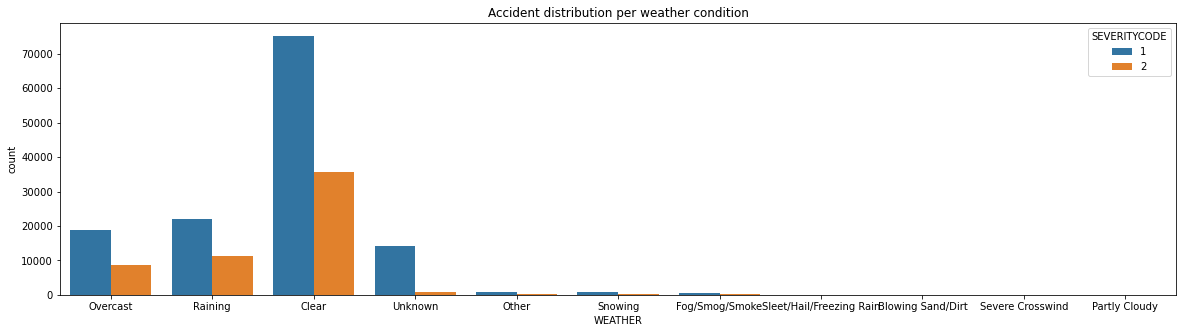

In [16]:
# Given that the number of registers with an HOUR value of 0 is 30K from 190K (around 15% of the total) we can't
# eliminate such a relevant part of the dataset. As long as there is some correlation between light condition and hour,
# we will discard the HOUR column to avoid what could be a source of confusion for the algorithm.
df.drop(columns = 'HOUR',inplace = True)

# Let's do a similar analysis with the rest of the features. First one will be the weather condition.
df_weather = df['WEATHER'].value_counts()
print(df_weather, '\n')
df_weather = df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize = True)
print(df_weather, '\n')
print("Low severity mean: ", df_weather.filter(like = ' 1' ,axis = 0).mean())
print("Low severity standard deviation: ", df_weather.filter(like = ' 1' ,axis = 0).std())
print("High severity mean: ", df_weather.filter(like = ' 2' ,axis = 0).mean())
print("High severity standard deviation: ", df_weather.filter(like = ' 2' ,axis = 0).std())
plt.figure(figsize = [20,5])
ax = sns.countplot(x = 'WEATHER', hue = 'SEVERITYCODE', data = df)
ax.set_title('Accident distribution per weather condition')

Dry               124300
Wet                47417
Unknown            15031
Ice                 1206
Snow/Slush           999
Other                131
Standing Water       115
Sand/Mud/Dirt         74
Oil                   64
Name: ROADCOND, dtype: int64 

ROADCOND        SEVERITYCODE
Dry             1               0.678166
                2               0.321834
Ice             1               0.773632
                2               0.226368
Oil             1               0.625000
                2               0.375000
Other           1               0.671756
                2               0.328244
Sand/Mud/Dirt   1               0.689189
                2               0.310811
Snow/Slush      1               0.833834
                2               0.166166
Standing Water  1               0.739130
                2               0.260870
Unknown         1               0.950303
                2               0.049697
Wet             1               0.668009
                2 

Text(0.5, 1.0, 'Accident distribution per road condition')

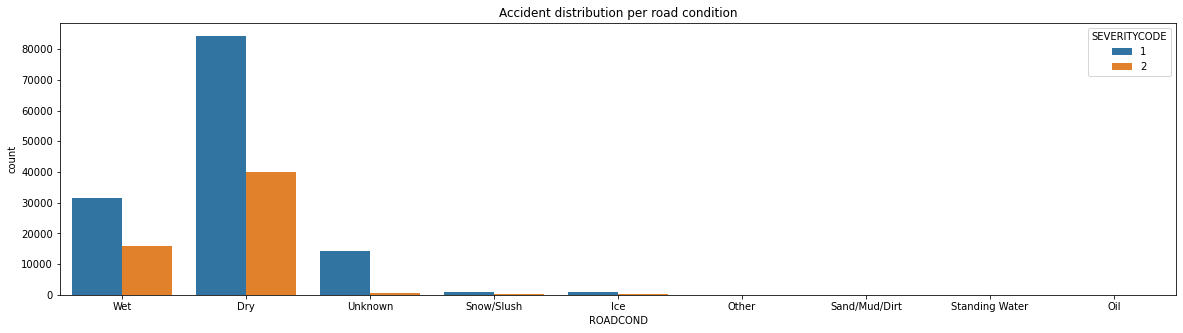

In [17]:
# We observe that most of the accidents are related just with three weather condition values: 'Overcast', 'Raining' and
# 'Clear', while there is also a significant number of them that appear as 'Unknown'. Let's continue analysing the values
# related to the road condition.
df_roadcond = df['ROADCOND'].value_counts()
print(df_roadcond,"\n")
df_roadcond = df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize = True)
print(df_roadcond,"\n")
print("Low severity mean: ", df_roadcond.filter(like = ' 1' ,axis = 0).mean())
print("Low severity standard deviation: ", df_roadcond.filter(like = ' 1' ,axis = 0).std())
print("High severity mean: ", df_roadcond.filter(like = ' 2' ,axis = 0).mean())
print("High severity standard deviation: ", df_roadcond.filter(like = ' 2' ,axis = 0).std())
plt.figure(figsize = [20,5])
ax = sns.countplot(x = 'ROADCOND', hue = 'SEVERITYCODE', data = df)
ax.set_title('Accident distribution per road condition')

Daylight                    116077
Dark - Street Lights On      48440
Unknown                      13456
Dusk                          5889
Dawn                          2502
Dark - No Street Lights       1535
Dark - Street Lights Off      1192
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64 

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   1               0.782410
                          2               0.217590
Dark - Street Lights Off  1               0.734899
                          2               0.265101
Dark - Street Lights On   1               0.701672
                          2               0.298328
Dark - Unknown Lighting   1               0.636364
                          2               0.363636
Dawn                      1               0.670663
                          2               0.329337
Daylight                  1               0.668082
                          2               0.331918
Du

Text(0.5, 1.0, 'Accident distribution per light condition')

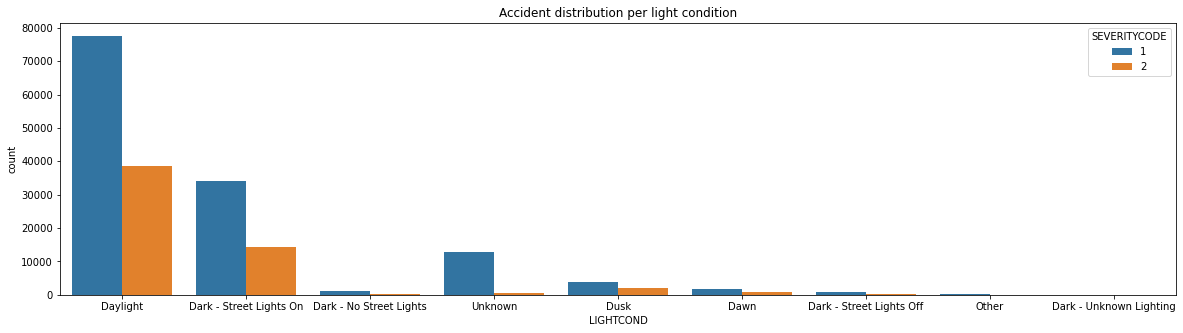

In [18]:
# We have a similar result than the one obtained in the weather condition feature. Most of the accidents are related
# either to a 'Wet' road or to a 'Dry' road, with a significant number of accidents with 'Unknown' conditions. The last
# feature to study will be the light condition.
df_lightcond = df['LIGHTCOND'].value_counts()
print(df_lightcond, '\n')
df_lightcond = df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize = True)
print(df_lightcond, '\n')
print("Low severity mean: ", df_lightcond.filter(like = ' 1' ,axis = 0).mean())
print("Low severity standard deviation: ", df_lightcond.filter(like = ' 1' ,axis = 0).std())
print("High severity mean: ", df_lightcond.filter(like = ' 2' ,axis = 0).mean())
print("High severity standard deviation: ", df_lightcond.filter(like = ' 2' ,axis = 0).std())
plt.figure(figsize = [20,5])
ax = sns.countplot(x = 'LIGHTCOND', hue = 'SEVERITYCODE', data = df)
ax.set_title('Accident distribution per light condition')

In [19]:
# Again, most of the cases are related only to two values, 'Daylight' and 'Dark - Street Lights On', and there is a
# significant number of cases with 'Unknown' light conditions. In this case, there is also a small although significant
# number of cases related to 'Dusk','Dawn' and 'Dark - No Street Lights / Street Lights Off' light condition.

# In that moment, we will simplify the dataframe, eliminating the data registers with "Unknown" value, as they do not
# provide information. We also will eliminate the values that have no significance compared to the rest.

# Let's start by 'WEATHER', keeping only the rows with 'Overcast', 'Raining' and 'Clear' values.
df.drop(df[df.WEATHER == 'Unknown'].index,inplace = True)
df.drop(df[df.WEATHER == 'Other'].index,inplace = True)
df.drop(df[(df.WEATHER == 'Blowing Sand/Dirt') | (df.WEATHER == 'Fog/Smog/Smoke') | (df.WEATHER == 'Partly Cloudy') |
          (df.WEATHER == 'Severe Crosswind') | (df.WEATHER == 'Sleet/Hail/Freezing Rain') |
          (df.WEATHER == 'Snowing')].index,inplace = True)

# We will do the same with 'ROADCOND', keeping the registers with 'Wet' and 'Dry' values, and also with 'Ice' and 'Snow'
df.drop(df[df.ROADCOND == 'Unknown'].index,inplace = True)
df.drop(df[df.ROADCOND == 'Other'].index,inplace = True)
df.drop(df[(df.ROADCOND == 'Oil') | (df.ROADCOND == 'Sand/Mud/Dirt') | (df.ROADCOND == 'Standing Water')].index,
        inplace = True)           
# 'Ice' and 'Snow' values will be grouped in a single value 'Ice' as they reflect similar conditions.        
df['ROADCOND'].replace('Snow/Slush', 'Ice', inplace = True)           

# We will also apply a similar simplification with the 'LIGHTCOND' feature.
df.drop(df[df.LIGHTCOND == 'Unknown'].index,inplace = True)
df.drop(df[df.LIGHTCOND == 'Other'].index,inplace = True)
df.drop(df[df.LIGHTCOND == 'Dark - Unknown Lighting'].index,inplace = True)           
# We will also convert the "Dark - Street Lights Off" in "Dark - No Street Lights" to have a single category, as long as
# both situations are equivalent in terms of light condition.
df['LIGHTCOND'].replace('Dark - Street Lights Off', 'Dark - No Street Lights', inplace = True)
# Once all of these changes are done, we have a dataset with the following size
df.shape

(168165, 6)

### One Hot Encoding

In [20]:
# The next step will be to transform the categorical variables into binary variables in order for the algorithms to work
# properly. We will apply the "One Hot encoding" technique
df = pd.concat([df,pd.get_dummies(df['WEATHER'])], axis = 1)
df = pd.concat([df,pd.get_dummies(df['ROADCOND'])], axis = 1)
df = pd.concat([df,pd.get_dummies(df['LIGHTCOND'])], axis = 1)
# As a final step, we drop the original columns
df.drop(['WEATHER','ROADCOND','LIGHTCOND'], axis = 1, inplace = True)
print(df.shape)
df.head()

(168165, 14)


,SEVERITYCODE,WEEKDAY,WEEK,Clear,Overcast,Raining,Dry,Ice,Wet,Dark - No Street Lights,Dark - Street Lights On,Dawn,Daylight,Dusk
0,2,2,13,0,1,0,0,0,1,0,0,0,1,0
1,1,2,51,0,0,1,0,0,1,0,1,0,0,0
2,1,3,47,0,1,0,1,0,0,0,0,0,1,0
3,1,4,13,1,0,0,1,0,0,0,0,0,1,0
4,2,2,05,0,0,1,0,0,1,0,0,0,1,0


### Dataset Bias

In [21]:
# As we said before, the dataset is strongly biased, as there are around 2/3 of the records belonging to one category
# (less severe accidents) and just 1/3 belonging to the other category (more severe accidents). This might affect the
# final result. The solution will be to undersample the records with 'SEVERITYCODE' = 1 in such a way that we have a
# similar number of records of each type. Sampling will be random, and we will reduce this subset in a 50%.
# In any case, later on we will measure the impact of the bias effect on the model accuracy.
print(df['SEVERITYCODE'].value_counts(),'\n')
df_unbiased = pd.concat([df[df.SEVERITYCODE == 2],df[df.SEVERITYCODE == 1].sample(frac = 0.5, random_state = 5)])
print(df_unbiased.shape, '\n')
df_unbiased.head()

1    112957
2     55208
Name: SEVERITYCODE, dtype: int64 

(111686, 14) 



,SEVERITYCODE,WEEKDAY,WEEK,Clear,Overcast,Raining,Dry,Ice,Wet,Dark - No Street Lights,Dark - Street Lights On,Dawn,Daylight,Dusk
0,2,2,13,0,1,0,0,0,1,0,0,0,1,0
4,2,2,05,0,0,1,0,0,1,0,0,0,1,0
7,2,2,16,1,0,0,1,0,0,0,0,0,1,0
9,2,0,12,1,0,0,1,0,0,0,0,0,1,0
14,2,6,13,1,0,0,1,0,0,0,1,0,0,0


### Feature Dataset and Train/Test splitting

In [22]:
# Once we have completed the dataset processing step, including the undersampling to reduce the bias effect, it is time
# to generate the features dataset and the labels array and do the train/test splitting.
x = df_unbiased[df_unbiased.columns[1:]]
y = df_unbiased['SEVERITYCODE'].values

print(x.shape)
print(y.shape)

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

# Once the train and test datasets have been generated, we apply data standardization
x_train = preprocessing.StandardScaler().fit(x_train).transform(x_train)
x_test = preprocessing.StandardScaler().fit(x_test).transform(x_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(111686, 13)
(111686,)
(89348, 13) (89348,)
(22338, 13) (22338,)


## Classification - Simple methods

### K Nearest Neighbor (KNN)

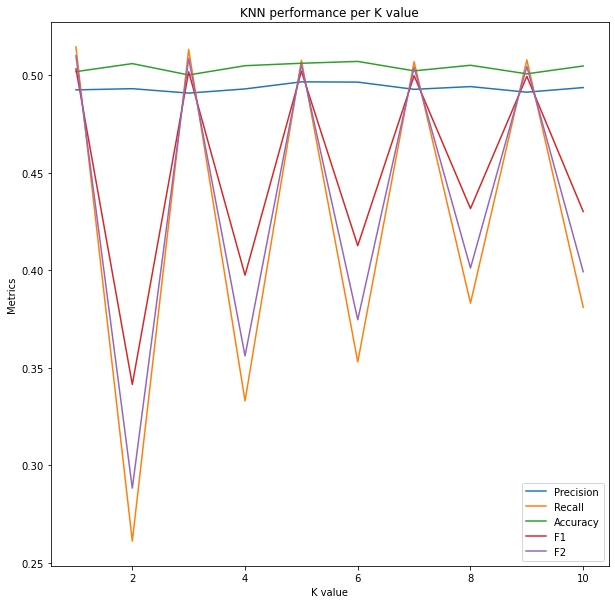

In [23]:
# The first method to evaluate will be KNN. Different values of the K parameter will be tested, measuring the performance
# of the model with the test set. The K value providing the maximum score will be kept. In this case, we will use two
# criteria: the main one will be maximizing the recall of the algorithm (in our case detecting the maximum number of 
# severe accidents as such) and the secondary will be doing this without having a big downgrade in precision and accuracy.

Ks = 10
f1_values = np.zeros(Ks)
f2_values = np.zeros(Ks)
recall_values = np.zeros(Ks)
precision_values = np.zeros(Ks)
accuracy_values = np.zeros(Ks)
confusion_values = []

for n in range(1, Ks + 1):
    KNNClass = KNeighborsClassifier(n_neighbors = n).fit(x_train, y_train)
    yhat = KNNClass.predict(x_test)
    f1_values[n-1] = f1_score(y_test, yhat, pos_label = 2, average = 'binary')
    f2_values[n-1] = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
    recall_values[n-1] = recall_score(y_test, yhat, pos_label = 2, average = 'binary')
    precision_values[n-1] = precision_score(y_test, yhat, pos_label = 2, average = 'binary')
    accuracy_values[n-1] = accuracy_score(y_test, yhat)
    confusion_values.append(confusion_matrix(y_test, yhat, labels = [1,2]))    
    
x_values = list(range(1 , Ks+1))
plt.figure(figsize = [10,10])
plt.plot(x_values, precision_values, label = "Precision")
plt.plot(x_values, recall_values, label = "Recall")
plt.plot(x_values, accuracy_values, label = "Accuracy")
plt.plot(x_values, f1_values, label = "F1")
plt.plot(x_values, f2_values, label = "F2")
plt.xlabel("K value")
plt.ylabel("Metrics")
plt.title("KNN performance per K value")
plt.legend()
plt.show()

In [24]:
# We can build a dataframe with all of these metrics and obtain the values that present the best relationship between
# recall and precision values, keeping a reasonable accuracy score.
metrics_dict = {'K':np.array(x_values), 'Recall':recall_values, 'Precision':precision_values, 'Accuracy':accuracy_values,
                'F1':f1_values, 'F2':f2_values}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.sort_values(by = ['Recall'], ascending = False, inplace = True)
print(metrics_df.max(axis = 0), '\n')
print(metrics_df.min(axis = 0), '\n')
metrics_df.head(10)

K            10.000000
Recall        0.514513
Precision     0.496607
Accuracy      0.507073
F1            0.503259
F2            0.509951
dtype: float64 

K            1.000000
Recall       0.261227
Precision    0.490834
Accuracy     0.500134
F1           0.341527
F2           0.288345
dtype: float64 



,K,Recall,Precision,Accuracy,F1,F2
0,1,0.514513,0.492486,0.501835,0.503259,0.509951
2,3,0.513235,0.490834,0.500134,0.501785,0.508593
8,9,0.507850,0.491302,0.500716,0.499439,0.504452
4,5,0.507667,0.496607,0.506133,0.502076,0.505416
6,7,0.506937,0.492769,0.502238,0.499753,0.504038
7,8,0.383169,0.494173,0.505103,0.431649,0.401193
9,10,0.381070,0.493674,0.504745,0.430124,0.399285
5,6,0.353049,0.496470,0.507073,0.412653,0.374697
3,4,0.333060,0.492975,0.504880,0.397538,0.356167
1,2,0.261227,0.493108,0.505954,0.341527,0.288345


In [25]:
# We will select the K value that provides the best balance between maximizing the recall score and having reasonable
# precision and accuracy values. As we can see, precision value is very similar for all K values, just slightly above a
# 49%. Accuracy values are also quite similar, just slightly above 50%. Given these values, we will choose K = 5, as it
# provides a good recall value, although not the maximum, while keeping reasonably high precision and accuracy. 

Kopt = 5
k_index = Kopt-1

print("Optimal K is ", Kopt, " with precision ", precision_values[k_index], " recall ", recall_values[k_index],
      " f1 value ", f1_values[k_index], " f2 value ", f2_values[k_index], " and accuracy value ", 
      accuracy_values[k_index], ".\n")
print("Resulting confusion matrix is:\n", confusion_values[k_index], "\n")

Optimal K is  5  with precision  0.49660714285714286  recall  0.5076670317634173  f1 value  0.5020761870373714  f2 value  0.5054158185519046  and accuracy value  0.5061330468260363 .

Resulting confusion matrix is:
 [[5744 5638]
 [5394 5562]] 



### Decision Tree

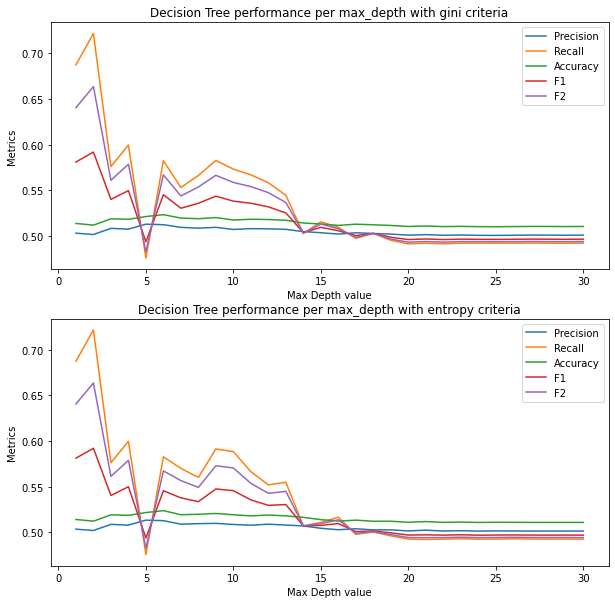

In [26]:
# Second method to evaluate will be Decision Tree. In this case optimal parameters (max_depth and criterion) will also
# be found and kept.

mdepth = 30
f1_values = np.zeros(2*mdepth)
f2_values = np.zeros(2*mdepth)
recall_values = np.zeros(2*mdepth)
precision_values = np.zeros(2*mdepth)
accuracy_values = np.zeros(2*mdepth)
confusion_values = []
parameters = []
i = 0

for n in range(1, mdepth + 1):
    for criteria_value in  ["gini", "entropy"]:
        DTreeClass = DecisionTreeClassifier(criterion = criteria_value, max_depth = n)
        DTreeClass.fit(x_train, y_train)
        yhat = DTreeClass.predict(x_test)
        f1_values[i] = f1_score(y_test, yhat, pos_label = 2, average = 'binary')
        f2_values[i] = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
        recall_values[i] = recall_score(y_test, yhat, pos_label = 2, average = 'binary')
        precision_values[i] = precision_score(y_test, yhat, pos_label = 2, average = 'binary')
        accuracy_values[i] = accuracy_score(y_test, yhat)
        confusion_values.append(confusion_matrix(y_test, yhat, labels = [1,2]))
        parameters.append([criteria_value, n])        
        i = i + 1

x_values = list(range(1, mdepth + 1))
y_values_gini = [i for i in range(0, 2 * mdepth) if i % 2 == 0]
y_values_entropy = [i for i in range(0, 2 * mdepth) if i % 2 == 1]
plt.figure(figsize = [10,10])
plt.subplot(211)
plt.plot(x_values, precision_values[y_values_gini], label = "Precision")
plt.plot(x_values, recall_values[y_values_gini], label = "Recall")
plt.plot(x_values, accuracy_values[y_values_gini], label = "Accuracy")
plt.plot(x_values, f1_values[y_values_gini], label = "F1")
plt.plot(x_values, f2_values[y_values_gini], label = "F2")
plt.xlabel("Max Depth value")
plt.ylabel("Metrics")
plt.title("Decision Tree performance per max_depth with gini criteria")
plt.legend()
plt.subplot(212)
plt.plot(x_values, precision_values[y_values_entropy], label = "Precision")
plt.plot(x_values, recall_values[y_values_entropy], label = "Recall")
plt.plot(x_values, accuracy_values[y_values_entropy], label = "Accuracy")
plt.plot(x_values, f1_values[y_values_entropy], label = "F1")
plt.plot(x_values, f2_values[y_values_entropy], label = "F2")
plt.xlabel("Max Depth value")
plt.ylabel("Metrics")
plt.title("Decision Tree performance per max_depth with entropy criteria")
plt.legend()
plt.show()

In [27]:
# Like in the previous case, we will build a dataframe with all of these metrics and will obtain the values that
# present the best relationship between recall, precision and accuracy values.

metrics_dict = {'Criterion':np.array([row[0] for row in parameters]),
                'Max. Depth':np.array([row[1] for row in parameters]), 'Recall':recall_values,
                'Precision':precision_values, 'Accuracy':accuracy_values, 'F1':f1_values, 'F2':f2_values}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.sort_values(by = ['Recall'], ascending = False, inplace = True)
print(metrics_df.max(axis = 0), '\n')
print(metrics_df.min(axis = 0), '\n')
metrics_df.head(15)

Criterion         gini
Max. Depth          30
Recall        0.721888
Precision     0.513154
Accuracy      0.523547
F1            0.592035
F2            0.663663
dtype: object 

Criterion      entropy
Max. Depth           1
Recall        0.475356
Precision     0.500789
Accuracy      0.510296
F1            0.493532
F2            0.482463
dtype: object 



,Criterion,Max. Depth,Recall,Precision,Accuracy,F1,F2
2,gini,2,0.721888,0.501776,0.512042,0.592035,0.663663
3,entropy,2,0.721888,0.501776,0.512042,0.592035,0.663663
0,gini,1,0.687568,0.503240,0.513878,0.581138,0.640637
1,entropy,1,0.687568,0.503240,0.513878,0.581138,0.640637
6,gini,4,0.599671,0.507650,0.518399,0.549837,0.578691
7,entropy,4,0.599671,0.507650,0.518399,0.549837,0.578691
17,entropy,9,0.591183,0.509599,0.520458,0.547368,0.572841
19,entropy,10,0.588353,0.508400,0.519071,0.545462,0.570412
16,gini,9,0.582877,0.509616,0.520324,0.543790,0.566587
11,entropy,6,0.582694,0.512565,0.523547,0.545385,0.567174


In [28]:
# As we can see, in the first cases (maximum recall values) there is no difference based on the criterion applied, we
# obtain the same values, depending only on the meximum depth parameter. Accuracy values are in the range between 
# 51.03% and 52.36%. Precision values are in the range between 50.08% and 51.31%. Recall values have a bigger margin, and
# go from 47.53% to 72.19%. Although we want a high value for the recall, in this case the high values obtained for
# maximum depth values 1 and 2 might be caused due to a high number of non-properly classified low severity accidents,
# this is the reason to obtain the lowest values of accuracy and precision. The best case seem to be using 'entropy' as
# the criterion and a maximum depth of 6.

depth_index = 11
OptCriterion = parameters[depth_index][0]
OptMaxDepth = parameters[depth_index][1]

print("Optimal criteria is ", OptCriterion, " using a maximum depth of ", OptMaxDepth, " with precision ",
      precision_values[depth_index], " recall ", recall_values[depth_index], " f1 value ", f1_values[depth_index],
      " f2 value ", f2_values[depth_index], " and accuracy value ", accuracy_values[depth_index], ".\n")
print("Resulting confusion matrix is:\n", confusion_values[depth_index], "\n")

Optimal criteria is  entropy  using a maximum depth of  6  with precision  0.5125652348454436  recall  0.5826944140197152  f1 value  0.5453846482422792  f2 value  0.5671742568275912  and accuracy value  0.5235473184707673 .

Resulting confusion matrix is:
 [[5311 6071]
 [4572 6384]] 



### Support Vector Machine (SVM)

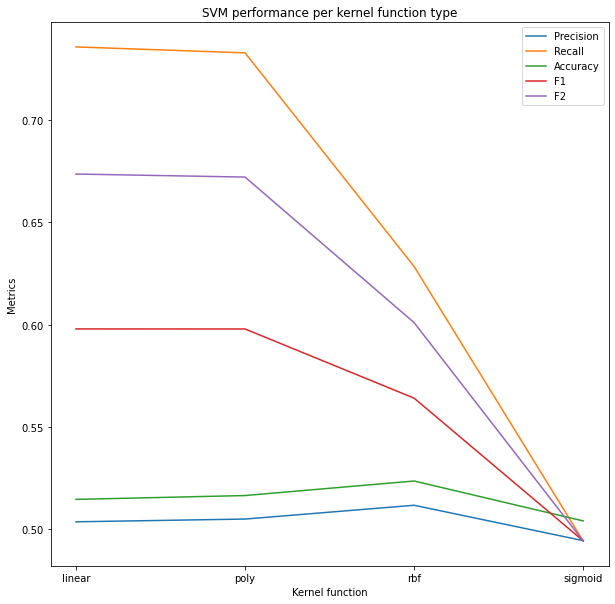

In [29]:
# Third method to consider will be Support Vector Machine. In this case, four options for the Kernel parameter can be
# used: "linear", "polynomial", "rbf" and "sigmoid"
# These options will be tested, using the same scoring metrics than in the previous cases (precision score, recall score,
# f1 score and confusion matrix).

kernel_values = ["linear", "poly", "rbf", "sigmoid"]
n_values = len(kernel_values)
f1_values = np.zeros(n_values)
f2_values = np.zeros(n_values)
recall_values = np.zeros(n_values)
precision_values = np.zeros(n_values)
accuracy_values = np.zeros(n_values)
confusion_values = []
i = 0

for kernel_value in kernel_values:
    SVMClass = svm.SVC(kernel = kernel_value).fit(x_train, y_train)
    yhat = SVMClass.predict(x_test)
    f1_values[i] = f1_score(y_test, yhat, pos_label = 2, average = 'binary')
    f2_values[i] = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
    recall_values[i] = recall_score(y_test, yhat, pos_label = 2, average = 'binary')
    precision_values[i] = precision_score(y_test, yhat, pos_label = 2, average = 'binary')
    accuracy_values[i] =  accuracy_score(y_test, yhat)
    confusion_values.append(confusion_matrix(y_test, yhat, labels = [1,2]))
    i = i + 1
    
plt.figure(figsize = [10,10])
plt.plot(kernel_values, precision_values, label = "Precision")
plt.plot(kernel_values, recall_values, label = "Recall")
plt.plot(kernel_values, accuracy_values, label = "Accuracy")
plt.plot(kernel_values, f1_values, label = "F1")
plt.plot(kernel_values, f2_values, label = "F2")
plt.xlabel("Kernel function")
plt.ylabel("Metrics")
plt.title("SVM performance per kernel function type")
plt.legend()
plt.show()

In [30]:
# We can also build a dataframe with all of these metrics for SVM, and choose the kernel function that presents the best
# relationship between recall, precision and accuracy values.
metrics_dict = {'Kernel Functions':np.array(kernel_values), 'Recall':recall_values, 'Precision':precision_values,
                'Accuracy':accuracy_values, 'F1':f1_values, 'F2':f2_values}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.sort_values(by = ['Recall'], ascending = False, inplace = True)
print(metrics_df.max(axis = 0), '\n')
print(metrics_df.min(axis = 0), '\n')
metrics_df.head()

Kernel Functions     sigmoid
Recall              0.736035
Precision            0.51144
Accuracy            0.523323
F1                  0.597843
F2                   0.67374
dtype: object 

Kernel Functions      linear
Recall              0.493885
Precision            0.49411
Accuracy             0.50376
F1                  0.493997
F2                   0.49393
dtype: object 



,Kernel Functions,Recall,Precision,Accuracy,F1,F2
0,linear,0.736035,0.503339,0.514325,0.597843,0.673740
1,poly,0.733114,0.504681,0.516206,0.597819,0.672258
2,rbf,0.628423,0.511440,0.523323,0.563928,0.600932
3,sigmoid,0.493885,0.494110,0.503760,0.493997,0.493930


In [31]:
# In this case, we clearly see that one Kernel function (sigmoid) provides the worst result in all of the metrics, so it
# is directly discarded. From the rest, linear and poly provide the highest (and similar) recall value, but lower 
# precision and accuracy. We will select rbf, that provides the best accuracy and precision values and a quite good
# recall value (around 63%).

OptKernel = 'rbf'
kernel_index = kernel_values.index(OptKernel)

print("Optimal kernel function is ", OptKernel, " with precision ", precision_values[kernel_index], " recall ",
      recall_values[kernel_index], " f1 value ", f1_values[kernel_index], " f2 value ", f2_values[kernel_index],
      " and accuracy value ", accuracy_values[kernel_index], ".\n")
print("Resulting confusion matrix is:\n", confusion_values[kernel_index], "\n")

Optimal kernel function is  rbf  with precision  0.511439607784876  recall  0.6284227820372399  f1 value  0.5639282496518961  f2 value  0.6009321649268582  and accuracy value  0.5233234846449996 .

Resulting confusion matrix is:
 [[4805 6577]
 [4071 6885]] 



### Logistic Regression

e:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
e:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
e:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
e:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
e:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


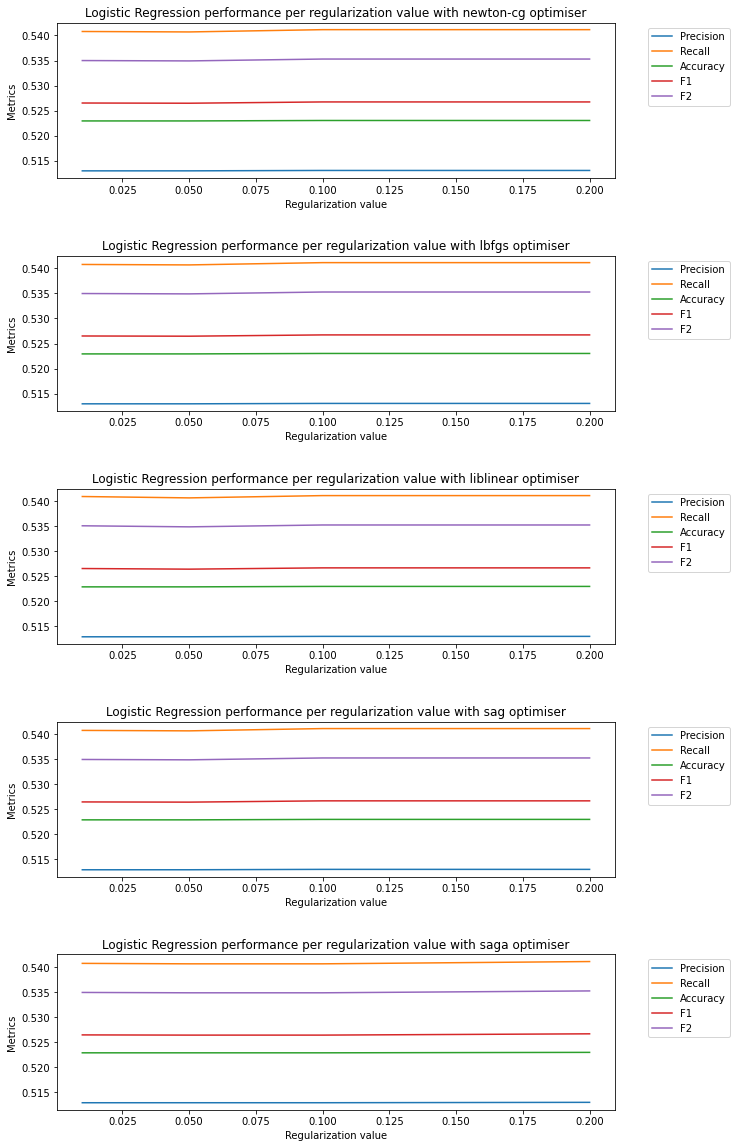

In [32]:
# The fourth method will be Logistic Regression. We will try two types of parameters: the optimiser to be used and the
# regularization value. We will also use f1_score to measure accuracy.

optimiser_values = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
reg_values = [0.01, 0.05 ,0.1, 0.2]
n_combinations = len(optimiser_values) * len(reg_values)
f1_values = np.zeros(n_combinations)
f2_values = np.zeros(n_combinations)
recall_values= np.zeros(n_combinations)
precision_values= np.zeros(n_combinations)
accuracy_values = np.zeros(n_combinations)
confusion_values = []
parameters = []
i = 0

for optimiser_value in optimiser_values:
    for reg_value in reg_values:
        LRClass = LogisticRegression(C = reg_value, solver = optimiser_value, max_iter = 10000).fit(x_train, y_train)
        yhat = LRClass.predict(x_test)
        f1_values[i] = f1_score(y_test, yhat, pos_label = 2, average = 'binary')
        f2_values[i] = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
        recall_values[i] = recall_score(y_test, yhat, pos_label = 2, average = 'binary')
        precision_values[i] = precision_score(y_test, yhat, pos_label = 2, average = 'binary')
        accuracy_values[i] =  accuracy_score(y_test, yhat)
        confusion_values.append(confusion_matrix(y_test, yhat, labels = [1,2]))
        parameters.append([optimiser_value, reg_value])        
        i = i + 1
        
n_values = len(reg_values)        
plt.figure(figsize = [10,20])
plt.subplots_adjust(hspace = 0.5)
plt.subplot(511)
plt.plot(reg_values, precision_values[0:n_values], label = "Precision")
plt.plot(reg_values, recall_values[0:n_values], label = "Recall")
plt.plot(reg_values, accuracy_values[0:n_values], label = "Accuracy")
plt.plot(reg_values, f1_values[0:n_values], label = "F1")
plt.plot(reg_values, f2_values[0:n_values], label = "F2")
plt.xlabel("Regularization value")
plt.ylabel("Metrics")
plt.title("Logistic Regression performance per regularization value with newton-cg optimiser")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(512)
plt.plot(reg_values, precision_values[n_values:2*n_values], label = "Precision")
plt.plot(reg_values, recall_values[n_values:2*n_values], label = "Recall")
plt.plot(reg_values, accuracy_values[n_values:2*n_values], label = "Accuracy")
plt.plot(reg_values, f1_values[n_values:2*n_values], label = "F1")
plt.plot(reg_values, f2_values[n_values:2*n_values], label = "F2")
plt.xlabel("Regularization value")
plt.ylabel("Metrics")
plt.title("Logistic Regression performance per regularization value with lbfgs optimiser")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(513)
plt.plot(reg_values, precision_values[2*n_values:3*n_values], label = "Precision")
plt.plot(reg_values, recall_values[2*n_values:3*n_values], label = "Recall")
plt.plot(reg_values, accuracy_values[2*n_values:3*n_values], label = "Accuracy")
plt.plot(reg_values, f1_values[2*n_values:3*n_values], label = "F1")
plt.plot(reg_values, f2_values[2*n_values:3*n_values], label = "F2")
plt.xlabel("Regularization value")
plt.ylabel("Metrics")
plt.title("Logistic Regression performance per regularization value with liblinear optimiser")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(514)
plt.plot(reg_values, precision_values[3*n_values:4*n_values], label = "Precision")
plt.plot(reg_values, recall_values[3*n_values:4*n_values], label = "Recall")
plt.plot(reg_values, accuracy_values[3*n_values:4*n_values], label = "Accuracy")
plt.plot(reg_values, f1_values[3*n_values:4*n_values], label = "F1")
plt.plot(reg_values, f2_values[3*n_values:4*n_values], label = "F2")
plt.xlabel("Regularization value")
plt.ylabel("Metrics")
plt.title("Logistic Regression performance per regularization value with sag optimiser")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.subplot(515)
plt.plot(reg_values, precision_values[4*n_values:5*n_values], label = "Precision")
plt.plot(reg_values, recall_values[4*n_values:5*n_values], label = "Recall")
plt.plot(reg_values, accuracy_values[4*n_values:5*n_values], label = "Accuracy")
plt.plot(reg_values, f1_values[4*n_values:5*n_values], label = "F1")
plt.plot(reg_values, f2_values[4*n_values:5*n_values], label = "F2")
plt.xlabel("Regularization value")
plt.ylabel("Metrics")
plt.title("Logistic Regression performance per regularization value with saga optimiser")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [33]:
# Next step will be building a dataframe with all of these metrics for the obtained results and analyse it, in order to
# decide which is the best parameters configuration to get a balanced set of metrics, trying at the same time to maximize
# the recall value.

metrics_dict = {'Optimisers':np.array([row[0] for row in parameters]),
                'Regularization Value':np.array([row[1] for row in parameters]), 'Recall':recall_values,
                'Precision':precision_values, 'Accuracy':accuracy_values, 'F1':f1_values, 'F2':f2_values}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.sort_values(by = ['Recall'], ascending = False, inplace = True)
print(metrics_df.max(axis = 0), '\n')
print(metrics_df.min(axis = 0), '\n')
metrics_df.head(10)

Optimisers                  saga
Regularization Value         0.2
Recall                  0.541165
Precision               0.513022
Accuracy                 0.52301
F1                      0.526718
F2                      0.535292
dtype: object 

Optimisers                 lbfgs
Regularization Value        0.01
Recall                  0.540708
Precision               0.512938
Accuracy                0.522921
F1                      0.526461
F2                      0.534918
dtype: object 



,Optimisers,Regularization Value,Recall,Precision,Accuracy,F1,F2
10,liblinear,0.10,0.541165,0.513022,0.523010,0.526718,0.535292
6,lbfgs,0.10,0.541165,0.513022,0.523010,0.526718,0.535292
15,sag,0.20,0.541165,0.513022,0.523010,0.526718,0.535292
14,sag,0.10,0.541165,0.513022,0.523010,0.526718,0.535292
11,liblinear,0.20,0.541165,0.513022,0.523010,0.526718,0.535292
7,lbfgs,0.20,0.541165,0.513022,0.523010,0.526718,0.535292
19,saga,0.20,0.541165,0.513022,0.523010,0.526718,0.535292
3,newton-cg,0.20,0.541165,0.513022,0.523010,0.526718,0.535292
2,newton-cg,0.10,0.541165,0.513022,0.523010,0.526718,0.535292
8,liblinear,0.01,0.540982,0.512938,0.522921,0.526587,0.535131


In [34]:
# In this case, we have a very similar result for all configurations. We will take the first configuration that
# provides the maximum recall value (that provide also the best precision and accuracy values).

max_recall = recall_values.argmax()
OptSolver = parameters[max_recall][0]
OptRegularization = parameters[max_recall][1]

print("Optimal solver is ", OptSolver, " using regularization value ", OptRegularization, " with precision ", 
      precision_values[max_recall], " recall ", recall_values[max_recall], " f1 value ", f1_values[max_recall],
      " f2 value ", f2_values[max_recall], " and accuracy value ", accuracy_values[max_recall], ".\n")
print("Resulting confusion matrix is:\n", confusion_values[max_recall], "\n")

Optimal solver is  newton-cg  using regularization value  0.1  with precision  0.5130224106602059  recall  0.5411646586345381  f1 value  0.526717896326567  f2 value  0.5352918871092973  and accuracy value  0.5230101172889247 .

Resulting confusion matrix is:
 [[5754 5628]
 [5027 5929]] 



## Classification - Ensemble Methods

In [35]:
# From the previous tests, we can observe that KNN provides the highest recall (maximizes the number of severity '2'
# accidents detected) although precision (ratio of severity '2' accidents properly detected) and accuracy (ratio of
# properly classified) values are not as good as we would like to. Accuracy value lies between 50.38% and 52.29% and
# precision between 51.05% and 53.36%. We can try some more complex techniques to look for an improvement of these
# values: they are called "ensemble methods".

# Ensemble methods combine the predictions of several base estimators built with a given learning algorithm in order to
# improve generalizability / robustness. Usually we talk about two families of ensemble methods, the one called
# "averaging methods", based on averaging the result of several independent estimators reducing variance, and the one
# called "boosting methods", where base estimators are built sequantially, each one trying to reduce the bias of the
# combined estimator. We will try the Random Forest from the averaging methods and the Gradient Tree Boost from the
# boosting methods. We will also try the Voting Classifier, that combines the result of several individual classifiers to
# make a decision.

### Random Forest

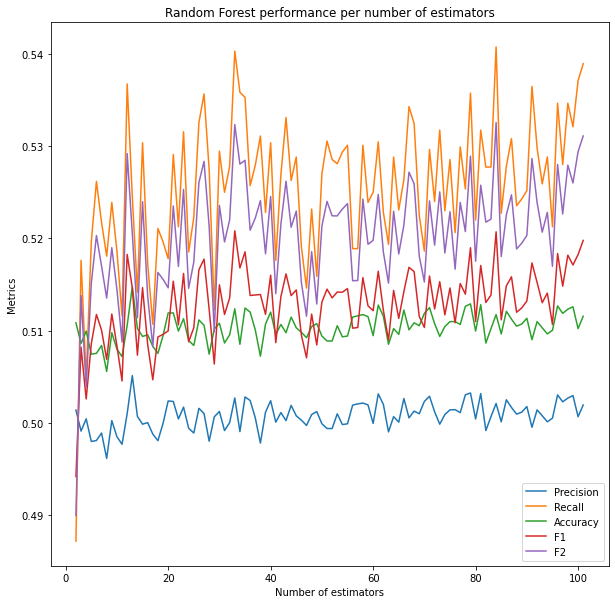

In [36]:
# Let's first try to improve the results using the Random Forest algorithm. We will use the same criteria that maximized
# the results in the Decision Tree classifier (entropy) and try a set of different values for the number of estimators
# (number of individual trees to be randomly generated).

min_range = 2
len_range = 100
max_range = min_range + len_range
f1_values = np.zeros(len_range)
f2_values = np.zeros(len_range)
recall_values = np.zeros(len_range)
precision_values = np.zeros(len_range)
accuracy_values = np.zeros(len_range)
confusion_values = []
parameter = []
i = 0

for estimator_value in range(min_range, max_range):
        RFClass = RandomForestClassifier(criterion = 'entropy', n_estimators = estimator_value)
        RFClass.fit(x_train, y_train)
        yhat = RFClass.predict(x_test)
        f1_values[i] = f1_score(y_test, yhat, pos_label = 2, average = 'binary')
        f2_values[i] = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
        recall_values[i] = recall_score(y_test, yhat, pos_label = 2, average = 'binary')
        precision_values[i] = precision_score(y_test, yhat, pos_label = 2, average = 'binary')
        accuracy_values[i] = accuracy_score(y_test, yhat)
        confusion_values.append(confusion_matrix(y_test, yhat, labels = [1,2]))        
        parameter.append(estimator_value)
        i = i + 1

x_values = list(range(min_range, max_range))
plt.figure(figsize = [10,10])
plt.plot(x_values, precision_values, label = "Precision")
plt.plot(x_values, recall_values, label = "Recall")
plt.plot(x_values, accuracy_values, label = "Accuracy")
plt.plot(x_values, f1_values, label = "F1")
plt.plot(x_values, f2_values, label = "F2")
plt.xlabel("Number of estimators")
plt.ylabel("Metrics")
plt.title("Random Forest performance per number of estimators")
plt.legend()
plt.show()

In [37]:
# Let's build a dataframe with all of these metrics and observe the maximum and minimum values for each metric.

metrics_dict = {'Estimators':np.array(parameter), 'Recall':recall_values, 'Precision':precision_values,
                'Accuracy':accuracy_values, 'F1':f1_values, 'F2':f2_values}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.sort_values(by = ['Recall'], ascending = False, inplace = True)
print(metrics_df.max(axis = 0), '\n')
print(metrics_df.min(axis = 0), '\n')
metrics_df.head(15)

Estimators    101.000000
Recall          0.540800
Precision       0.505098
Accuracy        0.514728
F1              0.520829
F2              0.532584
dtype: float64 

Estimators    2.000000
Recall        0.487130
Precision     0.496110
Accuracy      0.505551
F1            0.494144
F2            0.489912
dtype: float64 



,Estimators,Recall,Precision,Accuracy,F1,F2
82,84,0.540800,0.502076,0.511729,0.520719,0.532584
31,33,0.540343,0.502675,0.512356,0.520829,0.532365
99,101,0.538974,0.501912,0.511550,0.519783,0.531130
98,100,0.537149,0.500638,0.510207,0.518251,0.529427
10,12,0.536783,0.500980,0.510565,0.518264,0.529219
89,91,0.536510,0.499490,0.508998,0.517338,0.528673
32,34,0.535871,0.499023,0.508506,0.516791,0.528072
77,79,0.535779,0.503215,0.512893,0.518987,0.528934
25,27,0.535688,0.500982,0.510565,0.517754,0.528367
33,35,0.535323,0.502786,0.512445,0.518545,0.528483


In [38]:
# This case is different than the rest. Given the way that the algorithm is built (generating a certain number of random
# decision trees as estimators and grouping them) sometimes it is not possible to define an optimal configuration. If the
# process is run again, we will surely get a different result. We can see that the recall metric lies in the interval
# 49.76% - 53.97%, precision in the interval 49.79% - 50.32% and accuracy in the interval 50.74% - 51.29%. As we can see,
# both precision and accuracy have less than 1% difference between maximum and minimum and are close to 50% and 51%
# respectively.

# So, for the Random Forest we will just get the number of estimators used when got the best relationship of these three
# magnitudes.

OptEstimators = 11
estim_index = parameter.index(OptEstimators)


print("Number of estimators used for maximum recall ", OptEstimators, " with precision ", precision_values[estim_index],
      " recall ", recall_values[estim_index], " f1 value ", f1_values[estim_index],
      " f2 value ", f2_values[estim_index], " and accuracy value ", accuracy_values[estim_index], ".\n")
print("Resulting confusion matrix is:\n", confusion_values[estim_index], "\n")

Number of estimators used for maximum recall  11  with precision  0.49764716327798986  recall  0.5115918218327857  f1 value  0.5045231558575994  f2 value  0.5087407192259518  and accuracy value  0.507162682424568 .

Resulting confusion matrix is:
 [[5724 5658]
 [5351 5605]] 



### Gradient Tree Boost

In [39]:
# The second ensemble method to try will be the Gradient Tree Boost. There are two parameters that we can use to look
# for the best result: the maximum depth of the trees and the learning rate. The last one is a value in the interval
# (0.0, 1.0], but tipically small values are used, we will try values up to 0.5. The maximum depths will be in the
# interval 1 to 10. We will use the standard number of estimators (100).

learning_rates = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
maximum_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n_values = len(learning_rates) * len(maximum_depths)
f1_values = np.zeros(n_values)
f2_values = np.zeros(n_values)
recall_values= np.zeros(n_values)
precision_values= np.zeros(n_values)
accuracy_values= np.zeros(n_values)
confusion_values = []
parameters = []
i = 0

for l_rate in learning_rates:
    for maximum_depth in maximum_depths:
        GradBoost = GradientBoostingClassifier(n_estimators = 100, learning_rate = l_rate, max_depth = maximum_depth)
        GradBoost.fit(x_train, y_train)
        yhat = GradBoost.predict(x_test)

        f1_values[i] = f1_score(y_test, yhat, pos_label = 2, average = 'binary')
        f2_values[i] = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
        recall_values[i] = recall_score(y_test, yhat, pos_label = 2, average = 'binary')
        precision_values[i] = precision_score(y_test, yhat, pos_label = 2, average = 'binary')
        accuracy_values[i] = accuracy_score(y_test, yhat)
        confusion_values.append(confusion_matrix(y_test, yhat, labels = [1,2]))  
        parameters.append([l_rate, maximum_depth])
        i = i + 1       

In [40]:
# Like in the rest of the cases, we will build a dataframe with all of these metrics and will obtain the values that
# present the best relationship between recall and precision values.
metrics_dict = {'Learning Rate':np.array([row[0] for row in parameters]),
                'Max Depth': np.array([row[1] for row in parameters]), 'Recall':recall_values,
                'Precision':precision_values, 'Accuracy':accuracy_values, 'F1':f1_values, 'F2':f2_values}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.sort_values(by = ['Recall'], ascending = False, inplace = True)
print(metrics_df.max(axis = 0), '\n')
print(metrics_df.min(axis = 0), '\n')
metrics_df.head(15)

Learning Rate     0.500000
Max Depth        10.000000
Recall            0.685013
Precision         0.513731
Accuracy          0.524353
F1                0.580456
F2                0.638974
dtype: float64 

Learning Rate    0.010000
Max Depth        1.000000
Recall           0.479828
Precision        0.498344
Accuracy         0.507834
F1               0.496131
F2               0.486219
dtype: float64 



,Learning Rate,Max Depth,Recall,Precision,Accuracy,F1,F2
0,0.01,1,0.685013,0.503590,0.514325,0.580456,0.638974
11,0.10,2,0.568364,0.510326,0.520817,0.537784,0.555724
21,0.20,2,0.565170,0.513731,0.524353,0.538224,0.554074
31,0.30,2,0.563892,0.512230,0.522742,0.536821,0.552742
2,0.01,3,0.563162,0.509538,0.519876,0.535010,0.551553
4,0.01,5,0.561975,0.512656,0.523144,0.536184,0.551367
51,0.50,2,0.555038,0.510880,0.521130,0.532044,0.545606
8,0.01,9,0.554034,0.509741,0.519921,0.530966,0.544570
13,0.10,4,0.553395,0.511042,0.521264,0.531376,0.544372
12,0.10,3,0.553213,0.511693,0.521936,0.531643,0.544378


In [41]:
# The combination of values that provides the best balance is using a learning rate of 0.2 with a maximum depth of 2. We
# use the default number of estimators (100).

OptEstimators = 100
OptLearningRate = 0.2
OptGTBMaxDepth = 2
gtb_index = parameters.index([OptLearningRate, OptGTBMaxDepth])

print("Optimal number of estimators is ", OptEstimators, " using learning rate value ", OptLearningRate,
      " with precision ", precision_values[gtb_index], " recall ", recall_values[gtb_index], " f1 value ", 
      f1_values[gtb_index], " f2 value ", f2_values[gtb_index], " and accuracy value ", 
      accuracy_values[gtb_index],".\n")
print("Resulting confusion matrix is:\n", confusion_values[gtb_index], "\n")

Optimal number of estimators is  100  using learning rate value  0.2  with precision  0.5137310213224924  recall  0.5651697699890471  f1 value  0.5382241731496372  f2 value  0.5540741271005959  and accuracy value  0.5243531202435312 .

Resulting confusion matrix is:
 [[5521 5861]
 [4764 6192]] 



### Voting Classifier

In [42]:
# Voting classifier will make use of the four individual classifiers we have evaluated, tuned with the optimal parameters
# found, and will combine the decisions in order to get either a majority (hard) or average (soft) voting. We will try
# both approaches and compare results.

KNNClass = KNeighborsClassifier(n_neighbors = Kopt)
DTreeClass = DecisionTreeClassifier(criterion = OptCriterion, max_depth = OptMaxDepth)
SVMClass = svm.SVC(kernel = OptKernel)
LRClass = LogisticRegression(C = OptRegularization, solver = OptSolver, max_iter = 10000)

# Hard voting (majority option) will be evaluated first. 

VClass_hard = VotingClassifier([('knn',KNNClass),('dt',DTreeClass),('svm',SVMClass),('lr',LRClass)], voting = 'hard')
VClass_hard.fit(x_train, y_train)
yhat = VClass_hard.predict(x_test)

# And then we will measure the results.

f1_value = f1_score(y_test, yhat, labels = [1,2])
f2_value = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
recall_value = recall_score(y_test, yhat, labels = [1,2])
precision_value = precision_score(y_test, yhat, labels = [1,2])
accuracy_value = accuracy_score(y_test, yhat)
confusion_value = confusion_matrix(y_test, yhat, labels = [1,2], normalize = 'all')  

print("With hard voting option the algorithm obtains precision ", precision_value, " recall ", recall_value,
      " accuracy ", accuracy_value," f1 value ", f1_value, " and f2 value ", f2_value, ".\n")
print("Resulting normalized confusion matrix is:\n", confusion_value, "\n")

# Afterwards we will evaluate soft voting (averaging option). Due to the algorithm construction, we have to activate the
# probability estimation option in the SVM estimator. Due to the high resources consumption we'll do that only for this
# case.

SVMClass2 = svm.SVC(kernel = OptKernel, probability = True)

VClass_soft = VotingClassifier([('knn',KNNClass),('dt',DTreeClass),('svm',SVMClass2),('lr',LRClass)], voting = 'soft')
VClass_soft.fit(x_train, y_train)
yhat = VClass_soft.predict(x_test)

# And again, we will measure the results of the classifier.

f1_value = f1_score(y_test, yhat, labels = [1,2])
f2_value = fbeta_score(y_test, yhat, beta = 2.0, pos_label = 2, average = 'binary')
recall_value = recall_score(y_test, yhat, labels = [1,2])
precision_value = precision_score(y_test, yhat, labels = [1,2])
accuracy_value = accuracy_score(y_test, yhat)
confusion_value = confusion_matrix(y_test, yhat, labels = [1,2], normalize = 'all')  

print("With soft voting option the algorithm obtains precision ", precision_value, " recall ", recall_value,
      " accuracy ", accuracy_value," f1 value ", f1_value, " and f2 value ", f2_value, ".\n")
print("Resulting normalized confusion matrix is:\n", confusion_value, "\n")

e:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
e:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


With hard voting option the algorithm obtains precision  0.5320395139435266  recall  0.5347039184677561  accuracy  0.523278717879846  f1 value  0.5333683887647342  and f2 value  0.5119419622462219 .

Resulting normalized confusion matrix is:
 [[0.27245053 0.23708479]
 [0.23963649 0.25082819]] 



e:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
e:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


With soft voting option the algorithm obtains precision  0.518291659674442  recall  0.5426989984185556  accuracy  0.5099829886292416  f1 value  0.530214592274678  and f2 value  0.4806983260821473 .

Resulting normalized confusion matrix is:
 [[0.27652431 0.23301101]
 [0.257006   0.23345868]] 



## Measuring bias effect

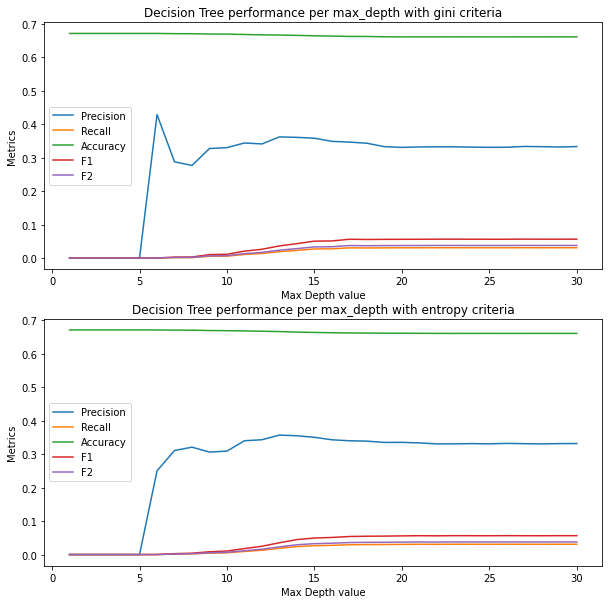

In [48]:
# The last step will be measuring the effect of having a biased dataset. We have been working with a set of values
# generated specifically to minimize (ideally eliminate) this effect. Now we will work with a train / test split taken
# directly from the "original" dataset and compare results, to get the relative impact of using the original dataset
# (biased) when generating the model.

x2 = df[df.columns[1:]]
y2 = df['SEVERITYCODE'].values

x2_train,x2_test,y2_train,y2_test = train_test_split(x2, y2, test_size = 0.3, random_state = 5)

# Once the train and test datasets have been generated, we apply data standardization
x2_train = preprocessing.StandardScaler().fit(x2_train).transform(x2_train)
x2_test = preprocessing.StandardScaler().fit(x2_test).transform(x2_test)

# The following step will be using this train/test split to generate and evaluate the model. In this case, we will use
# the Decision Tree algorithm. It obtains similar scores than the other methods and it is fast. To provide more
# information, instead of a single test with the optimum parameters, we will calculate also the optimum parameter in this
# case.

mdepth = 30
f1_values = np.zeros(2*mdepth)
f2_values = np.zeros(2*mdepth)
recall_values = np.zeros(2*mdepth)
precision_values = np.zeros(2*mdepth)
accuracy_values = np.zeros(2*mdepth)
confusion_values = []
parameters = []
i = 0

for n in range(1, mdepth + 1):
    for criteria_value in  ["gini", "entropy"]:
        DTreeClass = DecisionTreeClassifier(criterion = criteria_value, max_depth = n)
        DTreeClass.fit(x2_train, y2_train)
        yhat2 = DTreeClass.predict(x2_test)
        f1_values[i] = f1_score(y2_test, yhat2, pos_label = 2, average = 'binary', zero_division = 0)
        f2_values[i] = fbeta_score(y2_test, yhat2, beta = 2.0, pos_label = 2, average = 'binary', zero_division = 0)
        recall_values[i] = recall_score(y2_test, yhat2, pos_label = 2, average = 'binary', zero_division = 0)
        precision_values[i] = precision_score(y2_test, yhat2, pos_label = 2, average = 'binary', zero_division = 0)
        accuracy_values[i] = accuracy_score(y2_test, yhat2)
        confusion_values.append(confusion_matrix(y2_test, yhat2, labels = [1,2]))
        parameters.append([criteria_value, n])        
        i = i + 1

x_values = list(range(1, mdepth + 1))
y2_values_gini = [i for i in range(0, 2 * mdepth) if i % 2 == 0]
y2_values_entropy = [i for i in range(0, 2 * mdepth) if i % 2 == 1]
plt.figure(figsize = [10,10])
plt.subplot(211)
plt.plot(x_values, precision_values[y2_values_gini], label = "Precision")
plt.plot(x_values, recall_values[y2_values_gini], label = "Recall")
plt.plot(x_values, accuracy_values[y2_values_gini], label = "Accuracy")
plt.plot(x_values, f1_values[y2_values_gini], label = "F1")
plt.plot(x_values, f2_values[y2_values_gini], label = "F2")
plt.xlabel("Max Depth value")
plt.ylabel("Metrics")
plt.title("Decision Tree performance per max_depth with gini criteria")
plt.legend()
plt.subplot(212)
plt.plot(x_values, precision_values[y2_values_entropy], label = "Precision")
plt.plot(x_values, recall_values[y2_values_entropy], label = "Recall")
plt.plot(x_values, accuracy_values[y2_values_entropy], label = "Accuracy")
plt.plot(x_values, f1_values[y2_values_entropy], label = "F1")
plt.plot(x_values, f2_values[y2_values_entropy], label = "F2")
plt.xlabel("Max Depth value")
plt.ylabel("Metrics")
plt.title("Decision Tree performance per max_depth with entropy criteria")
plt.legend()
plt.show()

In [49]:
# Building the dataframe also in this case, we will be able to compare all of the metrics.
metrics_dict = {'Criterion':np.array([row[0] for row in parameters]),
                'Max. Depth':np.array([row[1] for row in parameters]), 'Recall':recall_values,
                'Precision':precision_values, 'Accuracy':accuracy_values, 'F1':f1_values, 'F2':f2_values}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.sort_values(by = ['Recall'], ascending = False, inplace = True)
print(metrics_df.max(axis = 0), '\n')
print(metrics_df.min(axis = 0), '\n')
metrics_df.head(20)

Criterion          gini
Max. Depth           30
Recall        0.0308962
Precision      0.428571
Accuracy       0.670882
F1            0.0565507
F2            0.0377456
dtype: object 

Criterion      entropy
Max. Depth           1
Recall               0
Precision            0
Accuracy      0.660476
F1                   0
F2                   0
dtype: object 



,Criterion,Max. Depth,Recall,Precision,Accuracy,F1,F2
52,gini,27,0.030896,0.333333,0.660714,0.056551,0.037746
51,entropy,26,0.030896,0.332039,0.660595,0.056532,0.037742
45,entropy,23,0.030896,0.330754,0.660476,0.056513,0.037739
59,entropy,30,0.030836,0.331606,0.660575,0.056425,0.037669
58,gini,30,0.030836,0.333116,0.660714,0.056447,0.037673
57,entropy,29,0.030836,0.331392,0.660555,0.056422,0.037669
44,gini,23,0.030836,0.332252,0.660634,0.056434,0.037671
47,entropy,24,0.030776,0.331388,0.660575,0.056321,0.037597
56,gini,29,0.030776,0.331603,0.660595,0.056324,0.037597
41,entropy,21,0.030776,0.333551,0.660773,0.056352,0.037602


In [50]:
# We can observe that having a biased input makes the model overfit towards the result with the greatest number of
# records. We obtain values of accuracy a lot greater than in previous cases (between 66% and 67%), while the recall
# values are below 3,11%. This indicates that the model is not detecting the high severity accidents as such, but as low
# severity accidents. This is an example of a model providing a good accuracy value (almost 70%) but being no useful for
# our objective. Given the proportion between low and high severity accidents (70% - 30%, approximately), classifying all
# the accidents as being low severity will provide a 70% accuracy, but a poor performance as we will not detect the
# events belonging to the other category, that is the most interesting for us.

## Model selection and final validation

In [51]:
# Based on the results obtained in the model evaluation, we will select the three algorithms providing the best overall
# performance, according to our criteria: SVM, Decision Tree and Gradient Tree Boost.

# As a last step we will rebuilt the model using the whole unbiased dataset and run it with the whole dataset to get the
# final metrics. We will also measure the execution time, to be able to compare the three chosen alternatives. For this
# purpose we will take the original features dataset, biased and unbiased, and apply data standardization.

x = preprocessing.StandardScaler().fit(x).transform(x)
x2 = preprocessing.StandardScaler().fit(x2).transform(x2)

# And we will use the unbiased dataset for training and the biased dataset for predicting results.

### Support Vector Machine (SVM)

In [52]:
# We will test first the SVM, using the function that we have defined as optimal.

start_time = time.time()
SVMClass = svm.SVC(kernel = OptKernel).fit(x, y)
fitting_time = time.time() - start_time

start_time = time.time()
yhat = SVMClass.predict(x2)
execution_time = time.time() - start_time

f1_value = f1_score(y2, yhat, pos_label = 2, average = 'binary')
f2_value = fbeta_score(y2, yhat, beta = 2.0, pos_label = 2, average = 'binary')
recall_value = recall_score(y2, yhat, pos_label = 2, average = 'binary')
precision_value = precision_score(y2, yhat, pos_label = 2, average = 'binary')
accuracy_value =  accuracy_score(y2, yhat)
confusion_value = confusion_matrix(y2, yhat, labels = [1,2])

# And we got the following results.

print("Results for SVM with ", OptKernel, " kernel function are a precision value of ", precision_value,
      " a recall value of ", recall_value, " a f1 value of ", f1_value, " a f2 value of ", f2_value,
      " and an accuracy value of ", accuracy_value, ".\n")
print("Resulting confusion matrix is:\n", confusion_value, "\n")
print("Fitting time is ", fitting_time, " seconds and execution time is ", execution_time, " seconds.\n")

Results for SVM with  rbf  kernel function are a precision value of  0.34668407471754753  a recall value of  0.6108353861759165  a f1 value of  0.44232396167391347  a f2 value of  0.5300608289715659  and an accuracy value of  0.49433592007849436 .

Resulting confusion matrix is:
 [[49407 63550]
 [21485 33723]] 

Fitting time is  750.9433445930481  seconds and execution time is  492.43181133270264  seconds.



### Decision Tree

In [53]:
# Second step will be testing the Decision Tree algorithm, using the parameters chosen as "optimal".

start_time = time.time()
DTreeClass = DecisionTreeClassifier(criterion = OptCriterion, max_depth = OptMaxDepth).fit(x, y)
fitting_time = time.time() - start_time

start_time = time.time()
yhat = DTreeClass.predict(x2)
execution_time = time.time() - start_time

f1_value = f1_score(y2, yhat, pos_label = 2, average = 'binary')
f2_value = fbeta_score(y2, yhat, beta = 2.0, pos_label = 2, average = 'binary')
recall_value = recall_score(y2, yhat, pos_label = 2, average = 'binary')
precision_value = precision_score(y2, yhat, pos_label = 2, average = 'binary')
accuracy_value =  accuracy_score(y2, yhat)
confusion_value = confusion_matrix(y2, yhat, labels = [1,2])

# And we got the following results.

print("Results for Decision Tree with ", OptCriterion, " criteria and maximum depth ", OptMaxDepth,
      " are a precision value of ", precision_value, " a recall value of ", recall_value, " a f1 value of ", f1_value,
      " a f2 value of ", f2_value, " and an accuracy value of ", accuracy_value, ".\n")
print("Resulting confusion matrix is:\n", confusion_value, "\n")
print("Fitting time is ", fitting_time, " seconds and execution time is ", execution_time, " seconds.\n")

Results for Decision Tree with  entropy  criteria and maximum depth  6  are a precision value of  0.34881130454154863  a recall value of  0.5955658600202869  a f1 value of  0.43995156251045353  a f2 value of  0.5217474095114172  and an accuracy value of  0.5022091398329022 .

Resulting confusion matrix is:
 [[51574 61383]
 [22328 32880]] 

Fitting time is  0.10422682762145996  seconds and execution time is  0.0310823917388916  seconds.



### Gradient Tree Boost

In [54]:
# Finally, we will measure the Gradient Tree Boost with the selected parameters.

start_time = time.time()
GradBoost = GradientBoostingClassifier(learning_rate = OptLearningRate, max_depth = OptGTBMaxDepth)
GradBoost.fit(x,y)
fitting_time = time.time() - start_time

start_time = time.time()
yhat = GradBoost.predict(x2)
execution_time = time.time() - start_time

f1_value = f1_score(y2, yhat, pos_label = 2, average = 'binary')
f2_value = fbeta_score(y2, yhat, beta = 2.0, pos_label = 2, average = 'binary')
recall_value = recall_score(y2, yhat, pos_label = 2, average = 'binary')
precision_value = precision_score(y2, yhat, pos_label = 2, average = 'binary')
accuracy_value =  accuracy_score(y2, yhat)
confusion_value = confusion_matrix(y2, yhat, labels = [1,2])

# And we got the following results.

print("Results for Gradient Tree Boost with ", OptGTBMaxDepth, " maximum depth and learning rate ", OptLearningRate,
      " are a precision value of ", precision_value, " a recall value of ", recall_value, " a f1 value of ", f1_value,
      " a f2 value of ", f2_value, " and an accuracy value of ", accuracy_value, ".\n")
print("Resulting confusion matrix is:\n", confusion_value, "\n")
print("Fitting time is ", fitting_time, " seconds and execution time is ", execution_time, " seconds.\n")

Results for Gradient Tree Boost with  2  maximum depth and learning rate  0.2  are a precision value of  0.3497793226462988  a recall value of  0.5541044776119403  a f1 value of  0.42884779835419795  a f2 value of  0.4961399980537805  and an accuracy value of  0.5154520857491155 .

Resulting confusion matrix is:
 [[56090 56867]
 [24617 30591]] 

Fitting time is  4.279759883880615  seconds and execution time is  0.16761350631713867  seconds.

